In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from june.records import RecordReader
import matplotlib.pyplot as plt
import pandas as pd
from utils import read_infections_and_deaths

No --data argument given - defaulting to:
/cosma6/data/dp004/dc-cues1/JUNE-private/data
No --configs argument given - defaulting to:
/cosma6/data/dp004/dc-cues1/JUNE-private/june/configs
--------------------------------------------------------------------------
By default, for Open MPI 4.0 and later, infiniband ports on a device
are not used by default.  The intent is to use UCX for these devices.
You can override this policy by setting the btl_openib_allow_ib MCA parameter
to true.

  Local host:              login7b
  Local adapter:           mlx5_0
  Local port:              1

--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   login7b
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.style.use(['science','no-latex'])
plt.style.reload_library()

In [5]:
%%time

# read one people df
read = RecordReader(
    results_path='/cosma6/data/dp004/dc-quer1/runs/olympia_fast/results/run_001/'
)
people_df = read.table_to_df('population')

CPU times: user 2min 9s, sys: 38.9 s, total: 2min 48s
Wall time: 2min 50s


In [6]:
n_runs = 9

In [39]:
%%time

infections_dfs, deaths_dfs = [], []
for run in range(n_runs):
    if run == 4:
        continue
    inf_df, death_df = read_infections_and_deaths(run=run)
    infections_dfs.append(inf_df)
    deaths_dfs.append(death_df)

CPU times: user 2min 27s, sys: 23.9 s, total: 2min 51s
Wall time: 3min


# Check effects vaccinating children

In [26]:
# Check effects children vaccination
labels= ['Baseline (Children not vaccinated)',
        '0-18 Vaccinated',
        '12-18 Vaccinated',
        '16-18 Vaccinated'
        ]

Text(0, 0.5, 'Daily Infections')

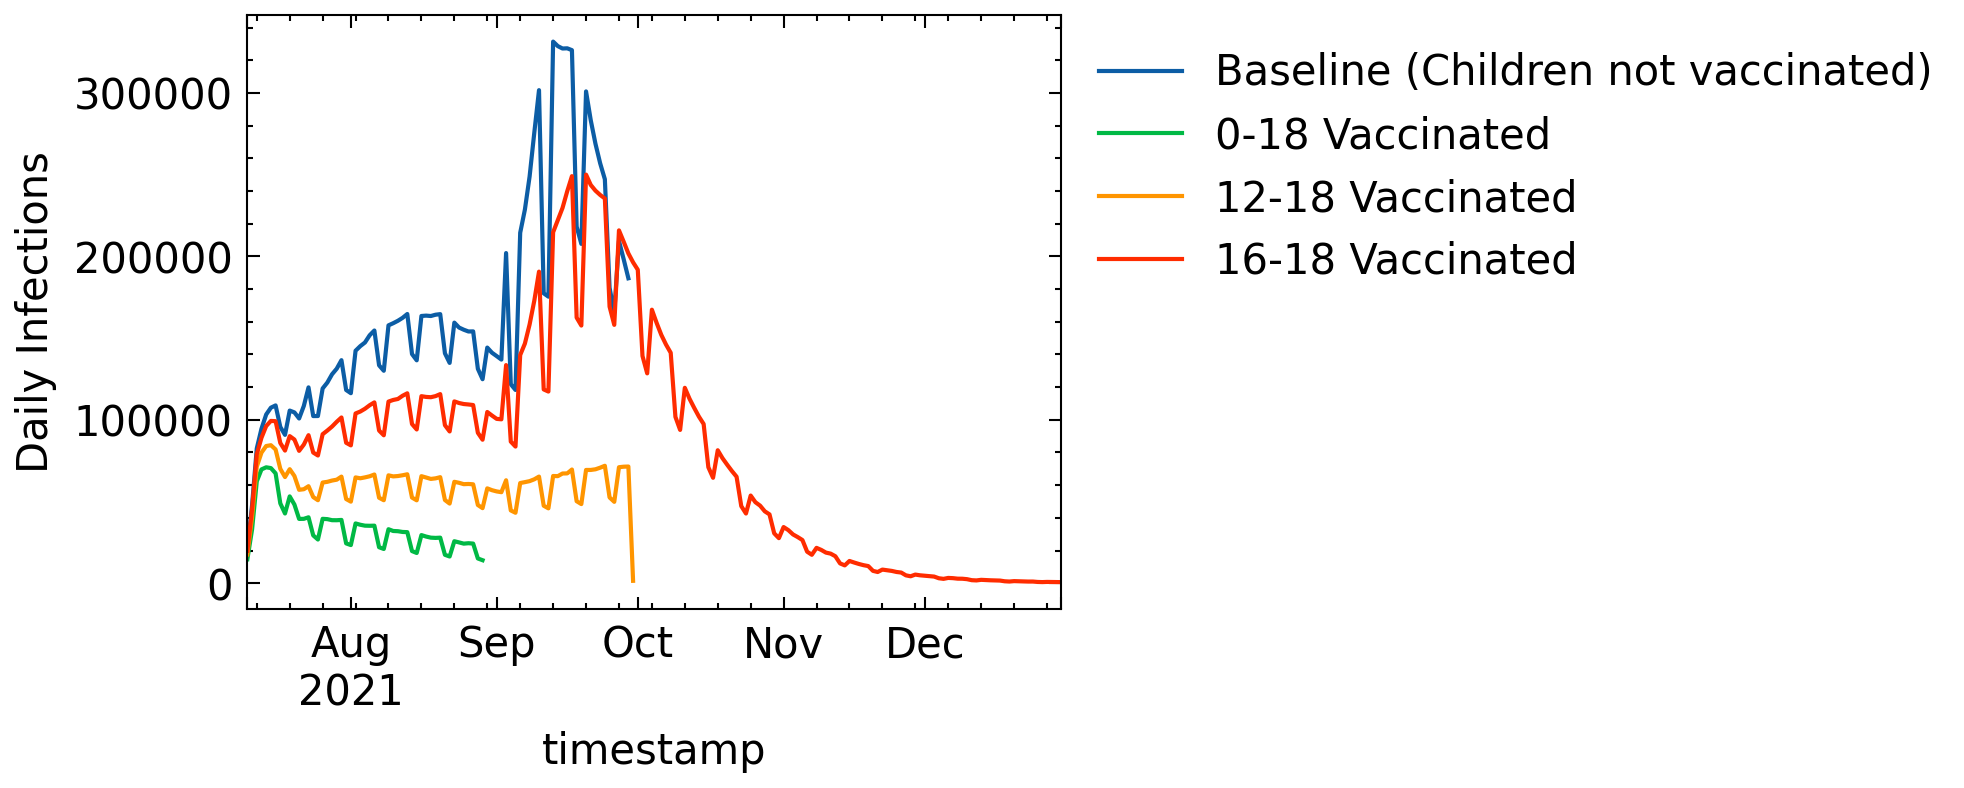

In [27]:
for run, df in enumerate(infections_dfs[:len(labels)]):
    df.groupby('timestamp').size().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily Infections')

Text(0, 0.5, 'Cumulative daily infections')

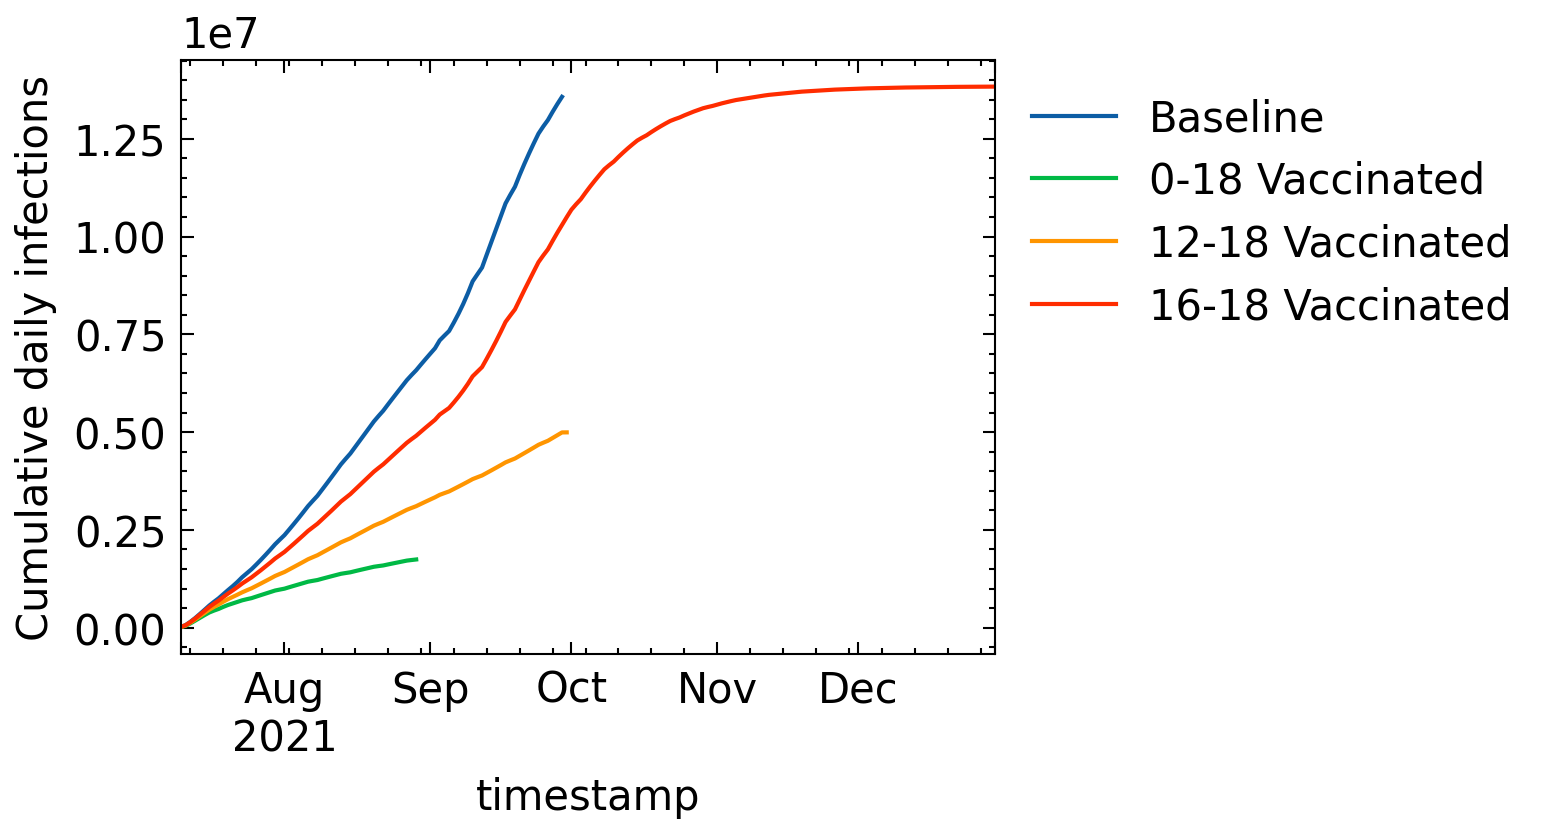

In [19]:
for run, df in enumerate(infections_dfs[:len(labels)]):
    df.groupby('timestamp').size().cumsum().plot(label=labels[run])
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative daily infections')

In [20]:
[deaths_dfs[i].groupby('timestamp').size().loc['2021-08-19'] for i in range(len(deaths_dfs))]

[193, 61, 98, 141]

Text(0, 0.5, 'Daily deaths')

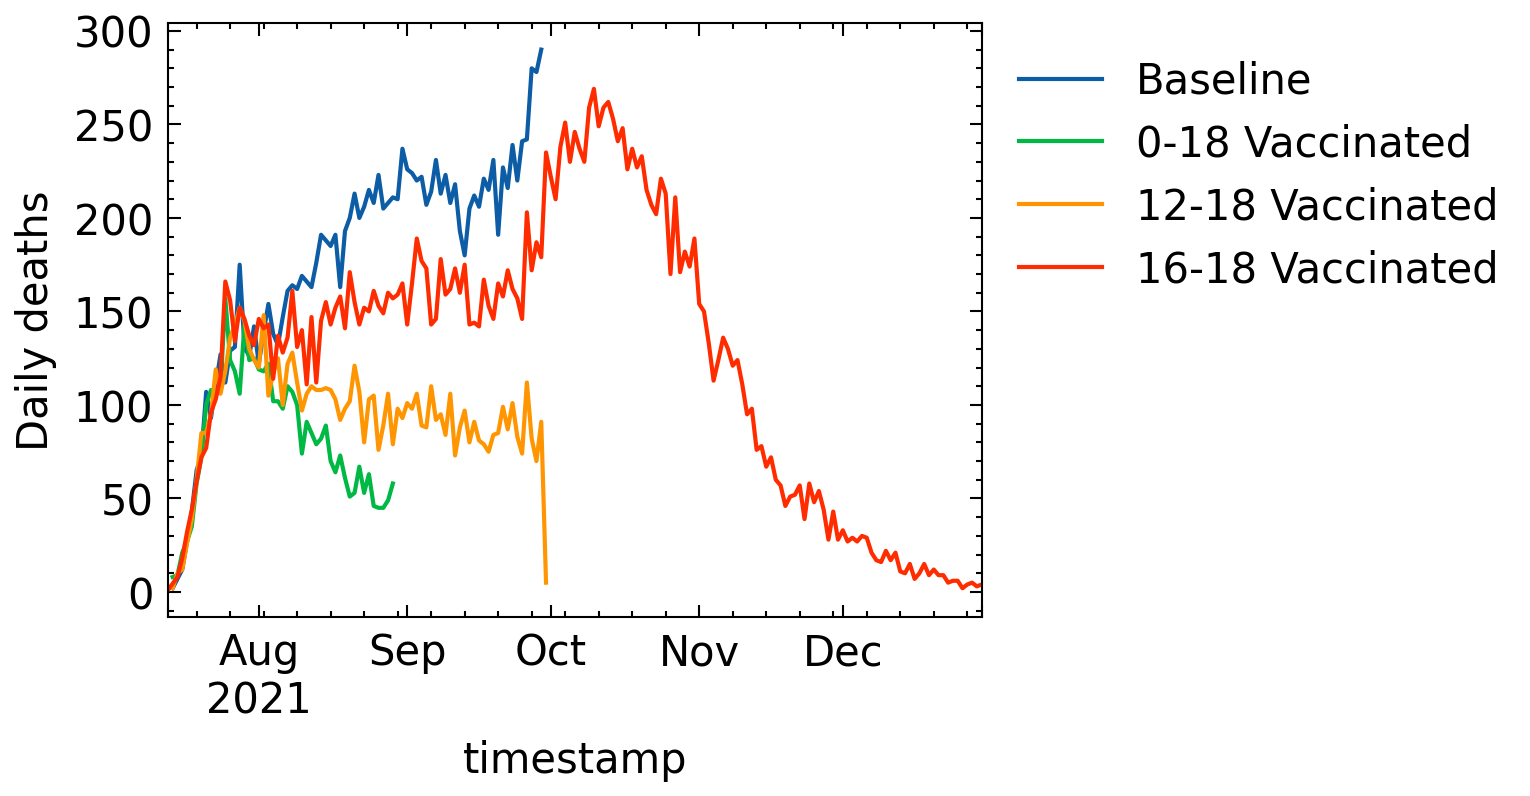

In [21]:
for run, df in enumerate(deaths_dfs[:len(labels)]):
    df.groupby('timestamp').size().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily deaths')

Text(0, 0.5, 'Cumulative deaths')

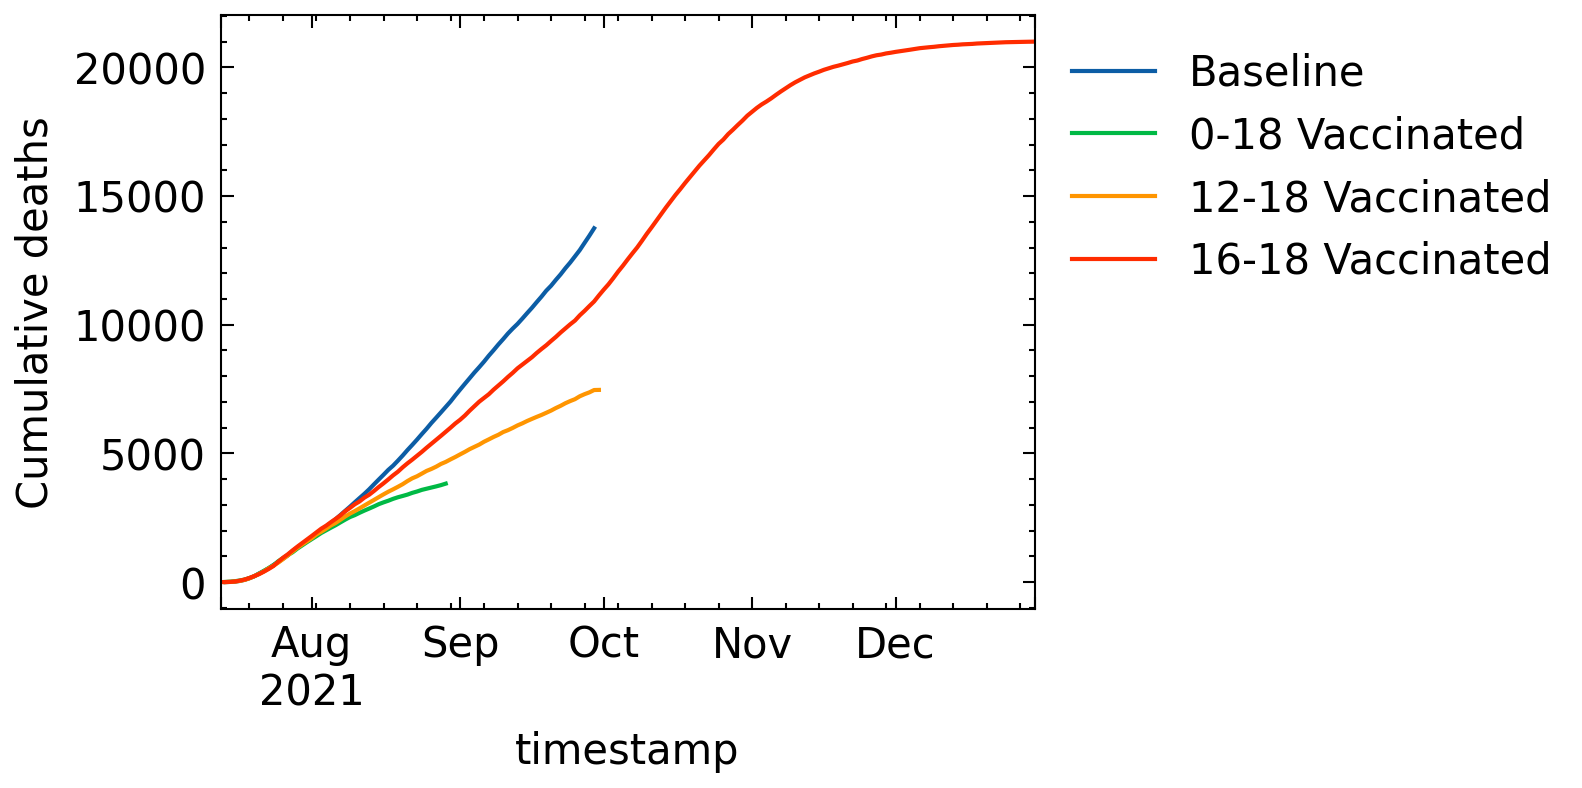

In [22]:
for run, df in enumerate(deaths_dfs[:len(labels)]):
    df.groupby('timestamp').size().cumsum().plot(label=labels[run])
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative deaths')

# Check effects percent adults vaccinated

In [40]:
labels= [
        '78% Adults Vaccinated (Current)',
        #'80% Adults Vaccinated',
        '85% Adults Vaccinated',
        '90% Adults Vaccinated',
        '100% Adults Vaccinated',
]

Text(0, 0.5, 'Daily Infections')

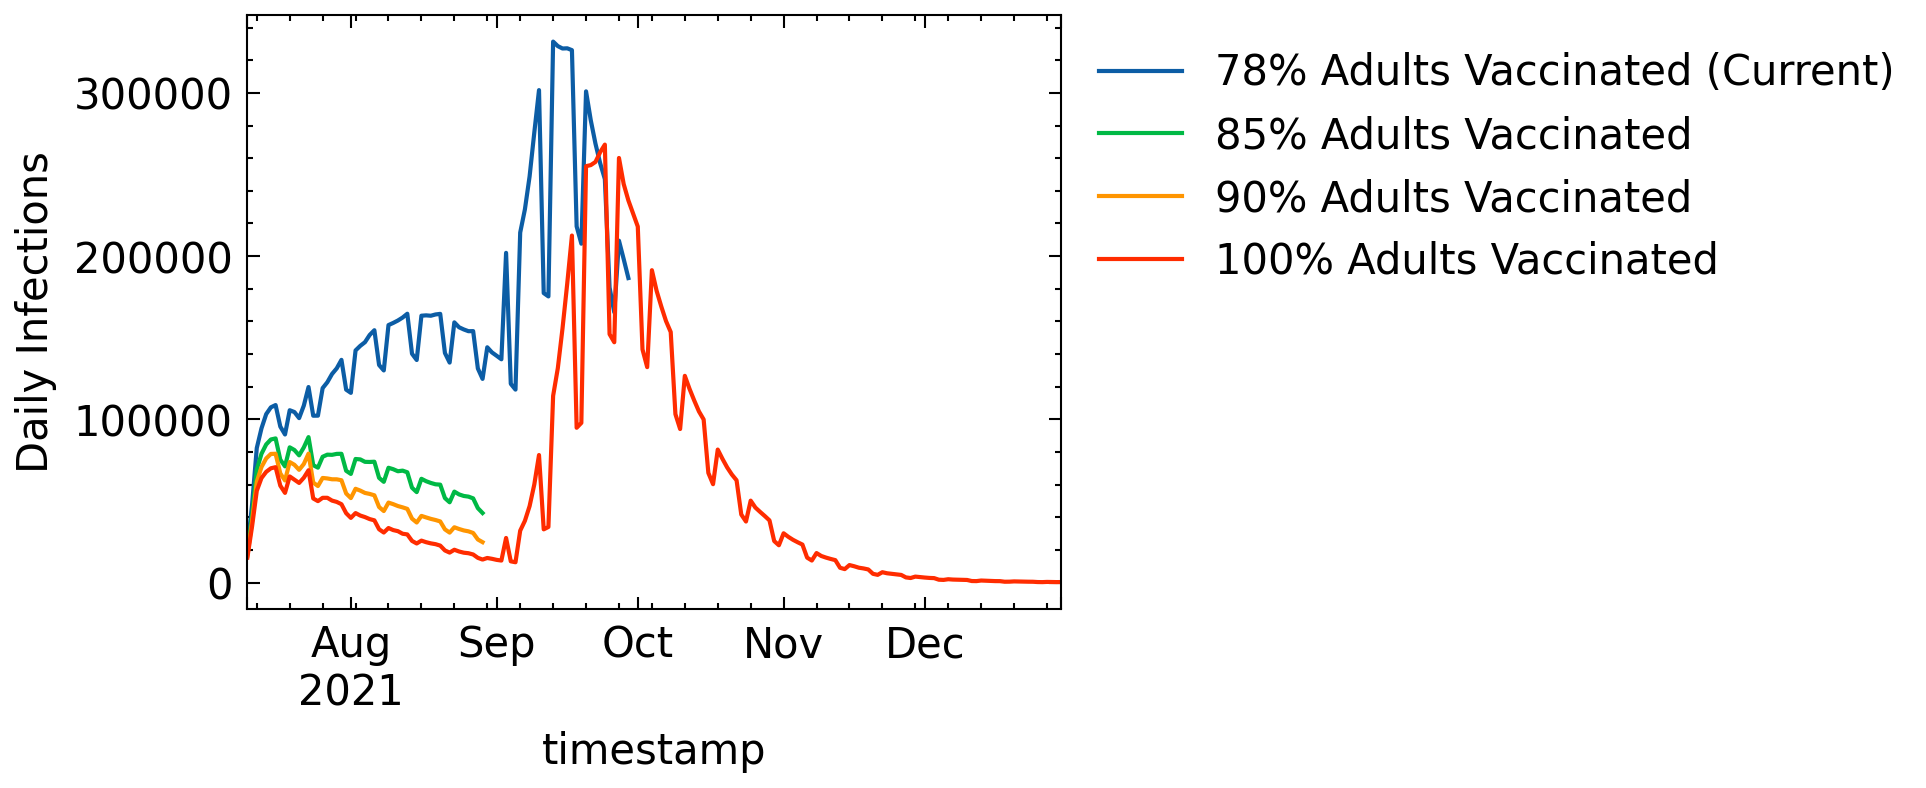

In [41]:
for run, df in enumerate([infections_dfs[0]] + infections_dfs[-3:]):
    df.groupby('timestamp').size().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily Infections')

Text(0, 0.5, 'Cumulative daily infections')

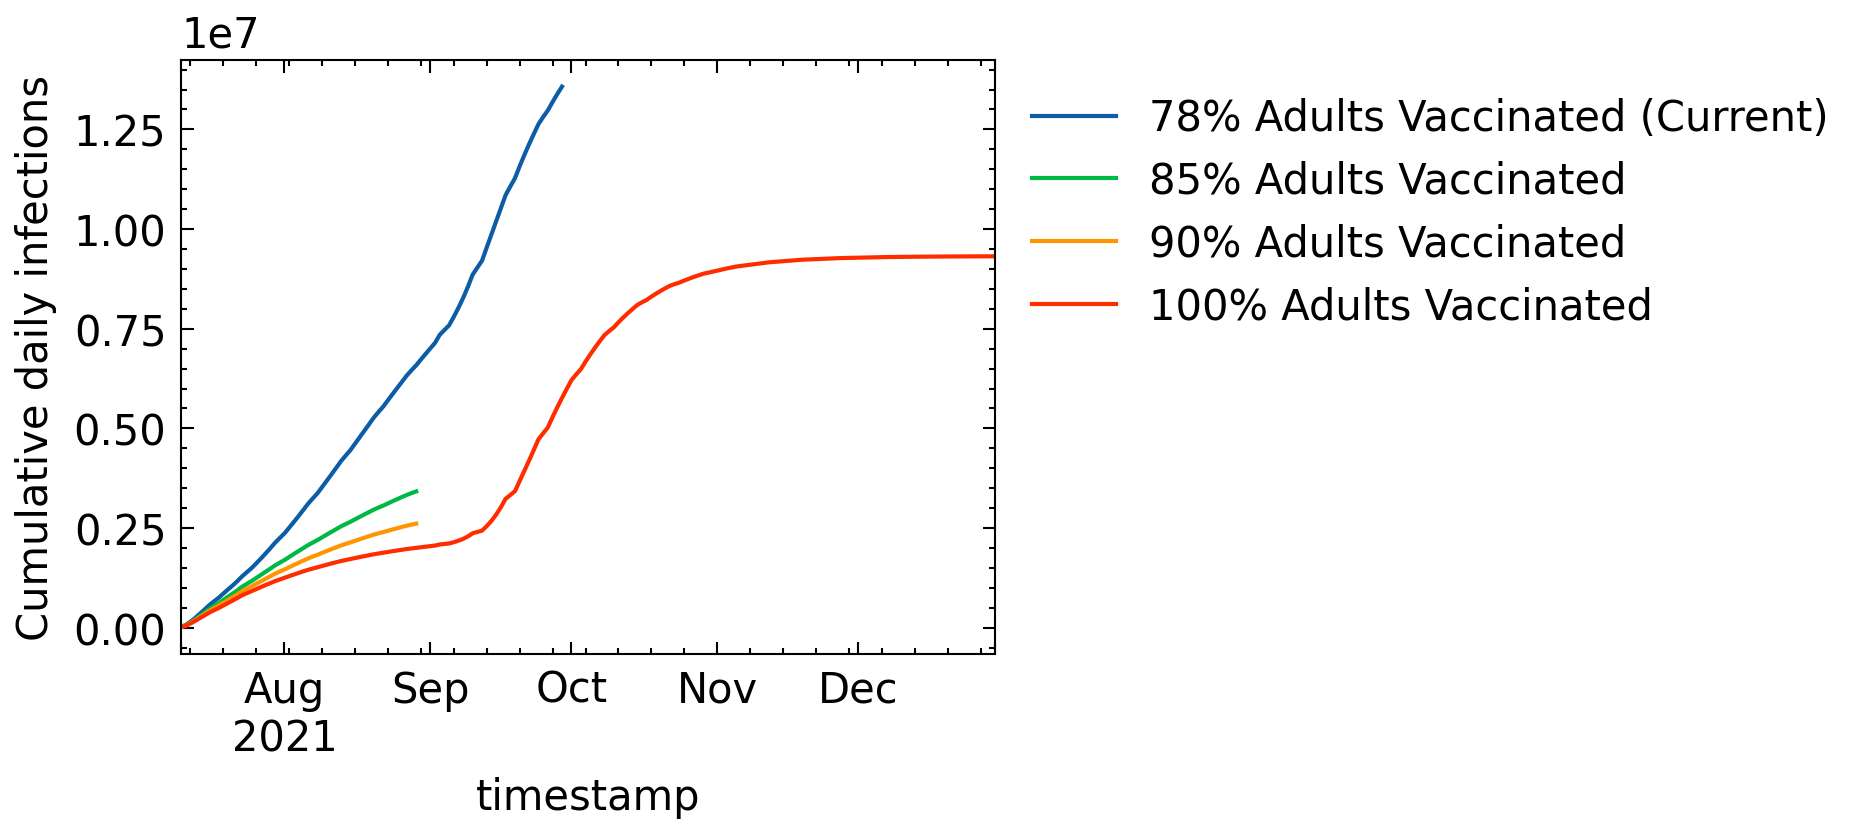

In [42]:
for run, df in enumerate([infections_dfs[0]] + infections_dfs[-3:]):
    df.groupby('timestamp').size().cumsum().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily Infections')
plt.ylabel('Cumulative daily infections')

Text(0, 0.5, 'Daily deaths')

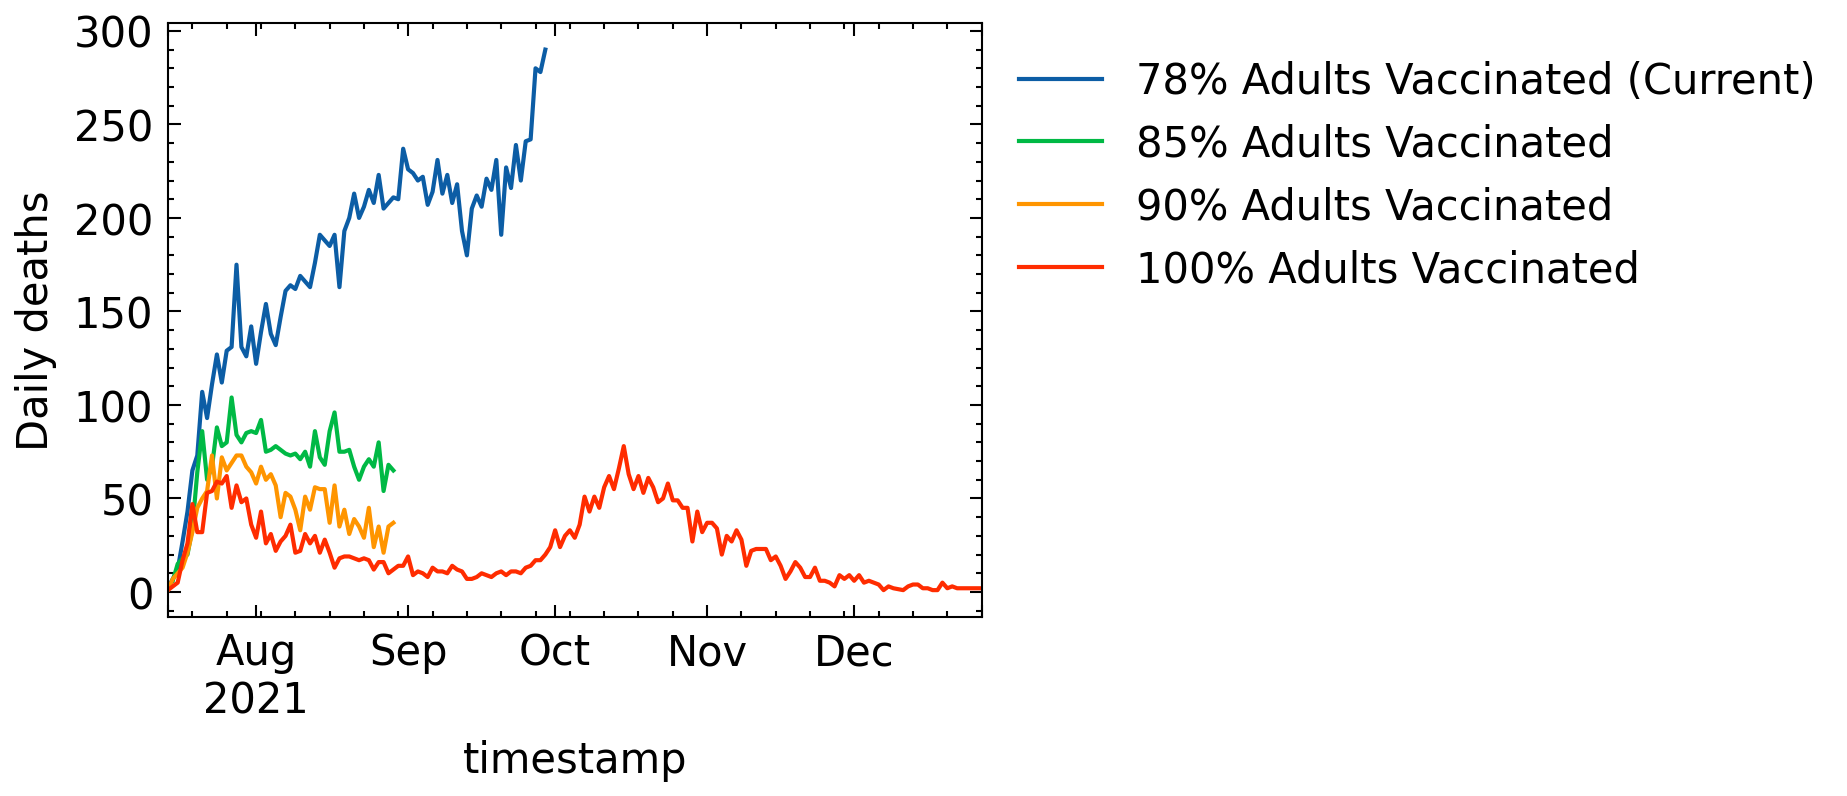

In [43]:
for run, df in enumerate([deaths_dfs[0]] + deaths_dfs[-3:]):
    df.groupby('timestamp').size().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Daily deaths')

Text(0, 0.5, 'Cumulative daily deaths')

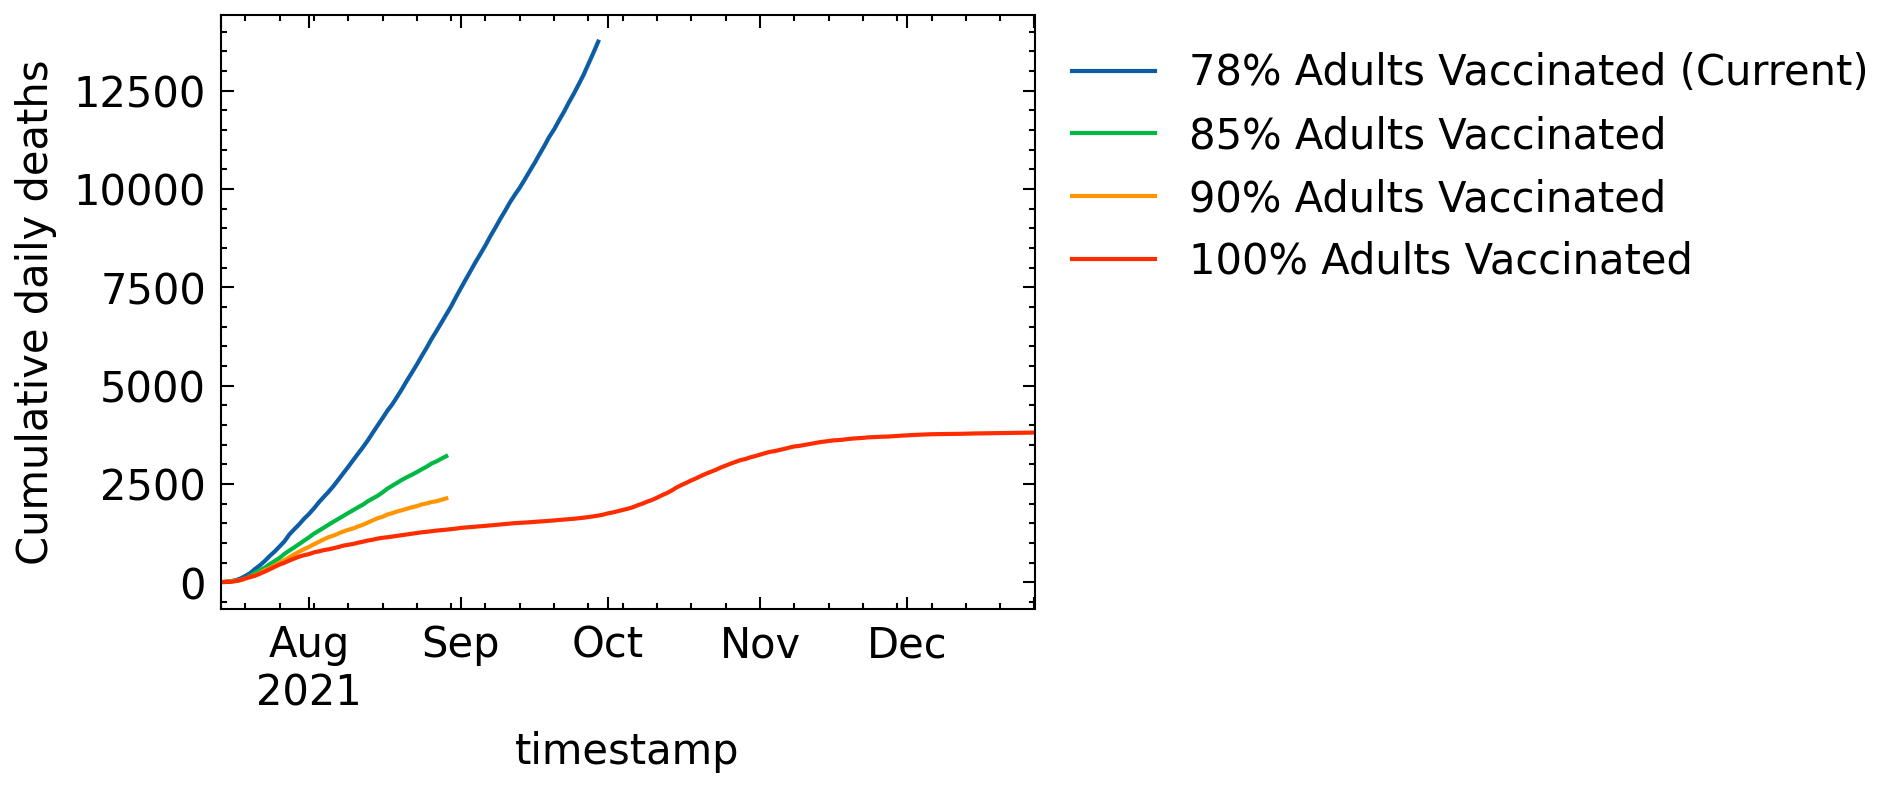

In [44]:
for run, df in enumerate([deaths_dfs[0]] + deaths_dfs[-3:]):
    df.groupby('timestamp').size().cumsum().plot(label=labels[run])
plt.legend()
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative daily deaths')

## Study the effects of different vaccine types

In [31]:
n_by_vaccine = people_df.groupby('vaccine_type').size()


In [38]:
n_by_vaccine

vaccine_type
astrazeneca    17228971
none            9030431
pfizer         26737600
dtype: int64

In [35]:
death_df = deaths_dfs[0]
infection_df = infections_dfs[0]

In [52]:
# Death rate by age az vs pf
age_bins = (0,12,18,25,35,45,55,65,75,90,150)
infected_by_age = infection_df.groupby([
    'vaccine_type',
    pd.cut(infection_df['age'],
            bins=age_bins)]).size()
death_by_age = death_df.groupby([
        'vaccine_type',
        pd.cut(death_df['age'],
            bins=age_bins)]).size()

/cosma/home/dp004/dc-cues1/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


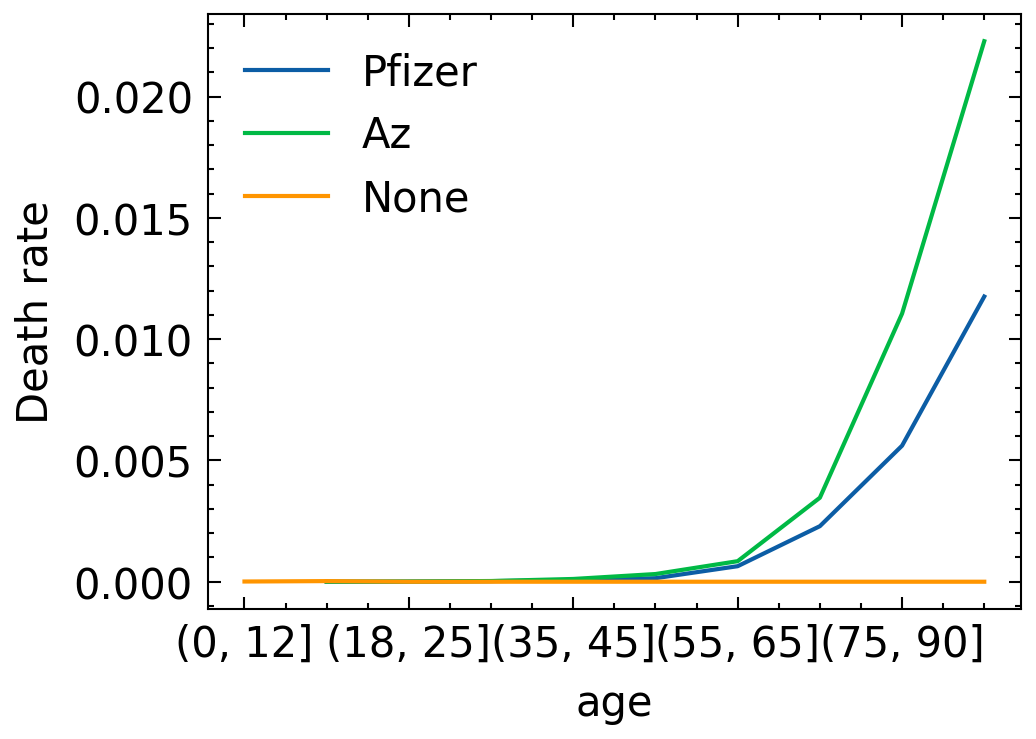

In [56]:
#TODO: Add health index
ax = (death_by_age/infected_by_age).loc['pfizer'].plot(label='Pfizer')
(death_by_age/infected_by_age).loc['astrazeneca'].plot(ax=ax,label='Az')
(death_by_age/infected_by_age).loc['none'].plot(ax=ax,label='None')
plt.ylabel('Death rate')
plt.legend()

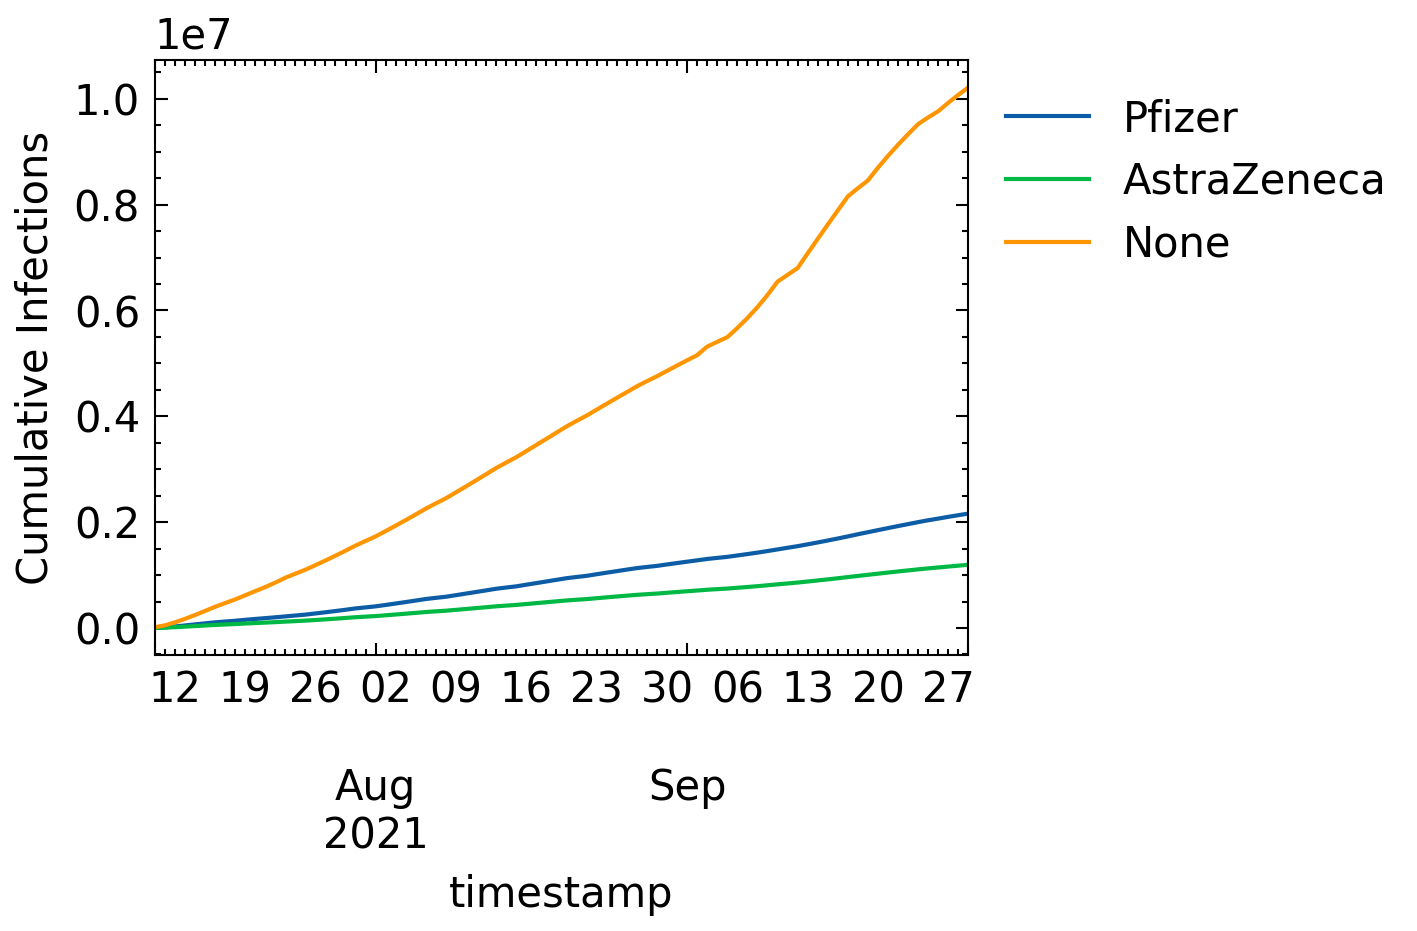

In [37]:
infection_df.groupby(['vaccine_type','timestamp']).size().loc['astrazeneca'].cumsum().plot(label=f'Pfizer')
infection_df.groupby(['vaccine_type','timestamp']).size().loc['pfizer'].cumsum().plot(label=f'AstraZeneca')
infection_df.groupby(['vaccine_type','timestamp']).size().loc['none'].cumsum().plot(label=f'None')


plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative Infections')
plt.show()

In [ ]:
death_df.groupby(['vaccine_type']).size()

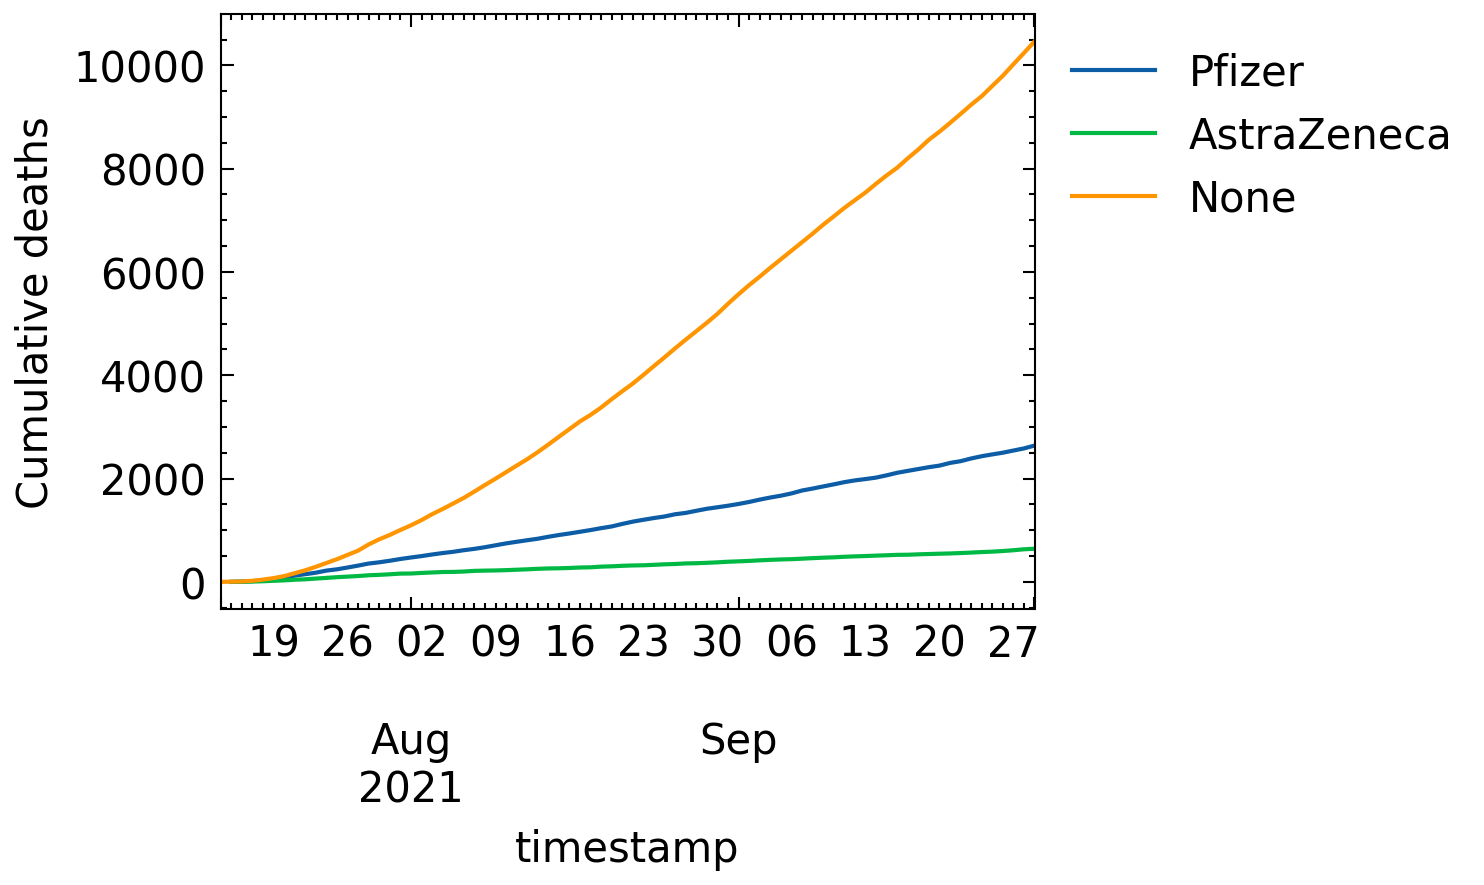

In [34]:
death_df.groupby(['vaccine_type','timestamp']).size().loc['astrazeneca'].cumsum().plot(label=f'Pfizer')
death_df.groupby(['vaccine_type','timestamp']).size().loc['pfizer'].cumsum().plot(label=f'AstraZeneca')
death_df.groupby(['vaccine_type','timestamp']).size().loc['none'].cumsum().plot(label=f'None')


plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Cumulative deaths')
plt.show()

In [ ]:
for run, df in enumerate(deaths_dfs):
    (
        df.groupby(['vaccine_type','timestamp']).size().cumsum()
        /n_by_vaccine
    ).loc['astrazeneca'].plot(label=f'AstraZeneca')
    
    (
        df.groupby(['vaccine_type','timestamp']).size().cumsum()
        /n_by_vaccine
    ).loc['none'].plot(label=f'None')
    
    (
        df.groupby(['vaccine_type','timestamp']).size().cumsum()
        /n_by_vaccine
    ).loc['pfizer'].plot(label=f'Pfizer')
    

    plt.legend(bbox_to_anchor=(1,1))
    plt.ylabel('Cumulative deaths')
    plt.show()

## Herd immunity: How many people got infected? Need to some the initial prevalence we assumed
### Obviously herd immunity threshold is a function of policies and vaccination too. We would need to state this very clearly